# Trodes Position


## Overview


_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on Spyglass.

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb)
- For additional info on DataJoint syntax, including table definitions and
  inserts, see
  [the Insert Data notebook](./01_Insert_Data.ipynb)

In this tutorial, we'll process position data extracted with Trodes Tracking by

- Defining parameters
- Processing raw position
- Extracting centroid and orientation
- Insert the results into the `TrodesPosV1` table
- Plotting the head position/direction results for quality assurance

The pipeline takes the 2D video pixel data of green/red LEDs, and computes:

- head position (in cm)
- head orientation (in radians)
- head velocity (in cm/s)
- head speed (in cm/s)


## Imports


In [1]:
import os
import datajoint as dj
import matplotlib.pyplot as plt

# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
dj.config.load("dj_local_conf.json")  # load config for database connection info

import spyglass.common as sgc
import spyglass.position as sgp

# ignore datajoint+jupyter async warnings
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)

[2024-01-12 13:47:50,578][INFO]: Connecting root@localhost:3306
[2024-01-12 13:47:50,652][INFO]: Connected root@localhost:3306


## Loading the data


First, we'll grab let us make sure that the session we want to analyze is inserted into the `RawPosition` table


In [2]:
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

# Define the name of the file that you copied and renamed
nwb_file_name = "minirec20230622.nwb"
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

In [3]:
sgc.common_behav.RawPosition() & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list
minirec20230622_.nwb,pos 0 valid times
minirec20230622_.nwb,pos 1 valid times


## Setting parameters


Parameters are set by the `TrodesPosParams` table, with a `default` set
available. To adjust the default, insert a new set into this table. The
parameters are...

- `max_separation`, default 9 cm: maximum acceptable distance between red and
  green LEDs.
  - If exceeded, the times are marked as NaNs and inferred by interpolation.
  - Useful when the inferred LED position tracks a reflection instead of the
    true position.
- `max_speed`, default 300.0 cm/s: maximum speed the animal can move.
  - If exceeded, times are marked as NaNs and inferred by interpolation.
  - Useful to prevent big jumps in position.
- `position_smoothing_duration`, default 0.100 s: LED position smoothing before
  computing average position to get head position.
- `speed_smoothing_std_dev`, default 0.100 s: standard deviation of the Gaussian
  kernel used to smooth the head speed.
- `front_led1`, default 1 (True), use `xloc`/`yloc`: Which LED is the front LED
  for calculating the head direction.
  - 1: LED corresponding to `xloc`, `yloc` in the `RawPosition` table is the
    front, `xloc2`, `yloc2` as the back.
  - 0: LED corresponding to `xloc2`, `yloc2` in the `RawPosition` table is the
    front, `xloc`, `yloc` as the back.

We can see these defaults with `TrodesPosParams().default_params`.


In [4]:
from pprint import pprint

parameters = sgp.v1.TrodesPosParams().default_params
pprint(parameters)

{'is_upsampled': 0,
 'led1_is_front': 1,
 'max_LED_separation': 9.0,
 'max_plausible_speed': 300.0,
 'orient_smoothing_std_dev': 0.001,
 'position_smoothing_duration': 0.125,
 'speed_smoothing_std_dev': 0.1,
 'upsampling_interpolation_method': 'linear',
 'upsampling_sampling_rate': None}


For the `minirec` demo file, only one LED is moving. The following paramset will
allow us to process this data.

In [5]:
trodes_params_name = "single_led"
trodes_params = {
    "max_separation": 10000.0,
    "max_speed": 300.0,
    "position_smoothing_duration": 0.125,
    "speed_smoothing_std_dev": 0.1,
    "orient_smoothing_std_dev": 0.001,
    "led1_is_front": 1,
    "is_upsampled": 0,
    "upsampling_sampling_rate": None,
    "upsampling_interpolation_method": "linear",
}
sgp.v1.TrodesPosParams.insert1(
    {
        "trodes_pos_params_name": trodes_params_name,
        "params": trodes_params,
    },
    skip_duplicates=True,
)
sgp.v1.TrodesPosParams()

trodes_pos_params_name name for this set of parameters,params
default,=BLOB=
single_led,=BLOB=
single_led_upsampled,=BLOB=


## Select interval


Later, we'll pair the above parameters with an interval from our NWB file and
insert into `TrodesPosSelection`.

First, let's select an interval from the `IntervalList` table.


In [6]:
sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start/end times for each interval
minirec20230622_.nwb,01_s1,=BLOB=
minirec20230622_.nwb,02_s2,=BLOB=
minirec20230622_.nwb,pos 0 valid times,=BLOB=
minirec20230622_.nwb,pos 1 valid times,=BLOB=
minirec20230622_.nwb,raw data valid times,=BLOB=


The raw position in pixels is in the `RawPosition` table is extracted from the
video data by the algorithm in Trodes. We have timepoints available for the
duration when position tracking was turned on and off, which may be a subset of
the video itself.

`fetch1_dataframe` returns the position of the LEDs as a pandas dataframe where
time is the index.


In [7]:
interval_list_name = "pos 0 valid times"  # pos # is epoch # minus 1
raw_position_df = (
    sgc.RawPosition()
    & {
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": interval_list_name,
    }
).fetch1_dataframe()
raw_position_df

[2024-01-12 13:47:54,251][WARNING]: Skipped checksum for file with hash: cce88743-51b1-5ad9-836a-260c938383dd, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/raw/minirec20230622_.nwb
[2024-01-12 13:47:54,254][WARNING]: Skipped checksum for file with hash: cce88743-51b1-5ad9-836a-260c938383dd, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/raw/minirec20230622_.nwb


,xloc1,yloc1,xloc2,yloc2
time,,,,
1.687475e+09,445,567,0,0
1.687475e+09,445,567,0,0
1.687475e+09,445,567,0,0
1.687475e+09,444,568,0,0
1.687475e+09,444,568,0,0
...,...,...,...,...
1.687475e+09,479,536,0,0
1.687475e+09,480,534,0,0
1.687475e+09,480,533,0,0


Let's just quickly plot the two LEDs to get a sense of the inputs to the pipeline:


Text(0.5, 1.0, 'Raw Position')

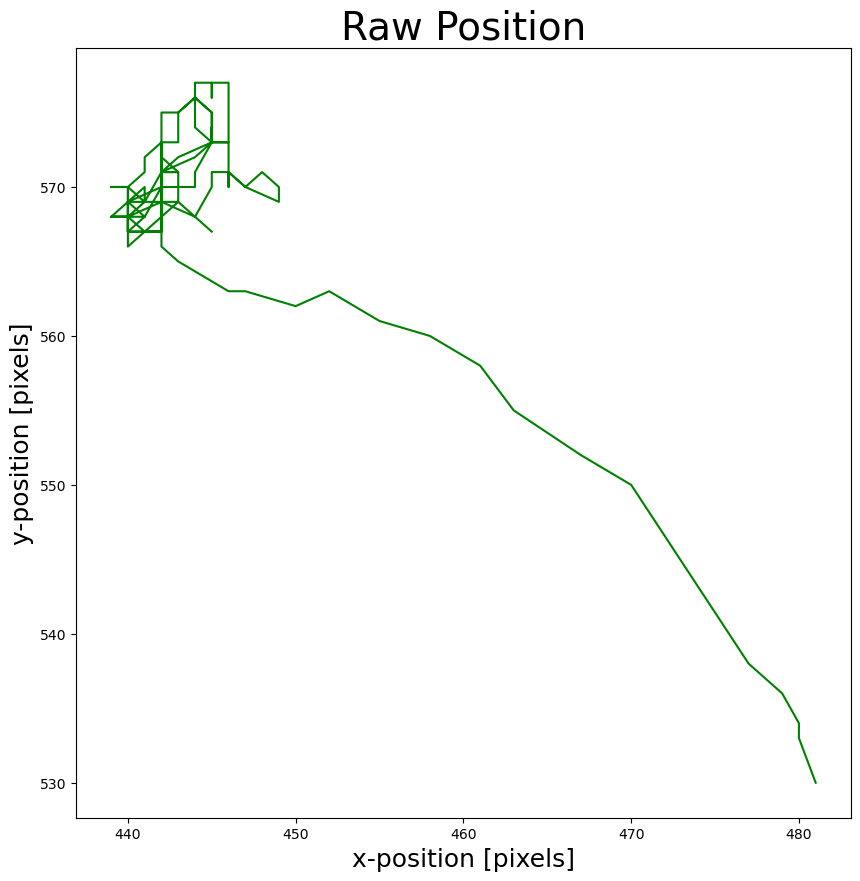

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(raw_position_df.xloc1, raw_position_df.yloc1, color="green")
# Uncomment for multiple LEDs
# ax.plot(raw_position_df.xloc2, raw_position_df.yloc2, color="red")
ax.set_xlabel("x-position [pixels]", fontsize=18)
ax.set_ylabel("y-position [pixels]", fontsize=18)
ax.set_title("Raw Position", fontsize=28)

## Pairing interval and parameters


To associate a set of parameters with a given interval, insert them into the
`TrodesPosSelection` table.


In [9]:
trodes_s_key = {
    "nwb_file_name": nwb_copy_file_name,
    "interval_list_name": interval_list_name,
    "trodes_pos_params_name": trodes_params_name,
}
sgp.v1.TrodesPosSelection.insert1(
    trodes_s_key,
    skip_duplicates=True,
)

Now let's check to see if we've inserted the parameters correctly:


In [10]:
trodes_key = (sgp.v1.TrodesPosSelection() & trodes_s_key).fetch1("KEY")

## Running the pipeline


We can run the pipeline for our chosen interval/parameters by using the
`TrodesPosV1.populate`.


In [11]:
sgp.v1.TrodesPosV1.populate(trodes_key)

Each NWB file, interval, and parameter set is now associated with a new analysis file and object ID.


In [12]:
sgp.v1.TrodesPosV1 & trodes_key

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,trodes_pos_params_name name for this set of parameters,analysis_file_name name of the file,position_object_id,orientation_object_id,velocity_object_id
minirec20230622_.nwb,pos 0 valid times,single_led,minirec20230622_AQQP7U6Y24.nwb,f519d1e4-0919-492a-85a4-6730cce26c10,6ae01b40-f5d9-4dd1-9203-76881d7bd339,002ce1f0-50a6-40b5-8b97-4b5a80140193


When we populatethe `TrodesPosV1` table, we automatically create an entry in the `PositionOutput` merge table.  
Since this table supports position information from multiple methods, it's best practive to access data through here. 

We can view the entry in this table:

In [13]:
from spyglass.position import PositionOutput

PositionOutput.TrodesPosV1 & trodes_key

merge_id,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,trodes_pos_params_name name for this set of parameters
15055247-04ba-ab0f-3b67-522f0ecc17e3,minirec20230622_.nwb,pos 0 valid times,single_led


To retrieve the results as a pandas DataFrame with time as the index, we use `PositionOutput.fetch1_dataframe`.
When doing so, we need to restric the merge table by the 

This dataframe has the following columns:

- `position_{x,y}`: X or Y position of the head in cm.
- `orientation`: Direction of the head relative to the bottom left corner
  in radians
- `velocity_{x,y}`: Directional change in head position over time in cm/s
- `speed`: the magnitude of the change in head position over time in cm/s


In [14]:
# get the merge id corresponding to our inserted trodes_key
merge_key = (PositionOutput.merge_get_part(trodes_key)).fetch1("KEY")
# use this to restrict PositionOutput and fetch the data
position_info = (PositionOutput & merge_key).fetch1_dataframe()
position_info

[2024-01-12 13:47:55,378][WARNING]: Skipped checksum for file with hash: c87c4027-855f-0181-d477-cf78242a7c20, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/minirec20230622/minirec20230622_AQQP7U6Y24.nwb


,video_frame_ind,position_x,position_y,orientation,velocity_x,velocity_y,speed
time,,,,,,,
1.687475e+09,0,22.250000,28.350000,0.905373,-0.148627,0.116866,0.189071
1.687475e+09,1,22.250000,28.350000,0.905373,-0.219948,0.162667,0.273565
1.687475e+09,2,22.250000,28.350000,0.905373,-0.298575,0.205042,0.362201
1.687475e+09,3,22.233333,28.366667,0.906022,-0.371837,0.233439,0.439041
1.687475e+09,4,22.216667,28.383333,0.906671,-0.424639,0.238911,0.487234
...,...,...,...,...,...,...,...
1.687475e+09,262,23.766667,27.066667,0.850225,2.738364,-3.998619,4.846400
1.687475e+09,263,23.933333,26.800000,0.841843,2.347307,-3.708857,4.389245
1.687475e+09,264,23.983333,26.716667,0.839258,1.907429,-3.237540,3.757652


`.index` on the pandas dataframe gives us timestamps.


In [15]:
position_info.index

Index([1687474800.1833298,  1687474800.216676,  1687474800.250001,
        1687474800.283326,  1687474800.316672, 1687474801.8658931,
       1687474801.8992178, 1687474801.9325643,  1687474801.965889,
        1687474801.999214,
       ...
        1687474810.265809,  1687474810.299134, 1687474810.3324802,
       1687474810.3658051,   1687474810.39913,  1687474810.432476,
        1687474810.465801,  1687474810.499126, 1687474810.5324721,
        1687474810.565797],
      dtype='float64', name='time', length=267)

## Examine results


We should always spot check our results to verify that the pipeline worked correctly.



### Plots



Let's plot some of the variables first:


Text(0.5, 1.0, 'Position')

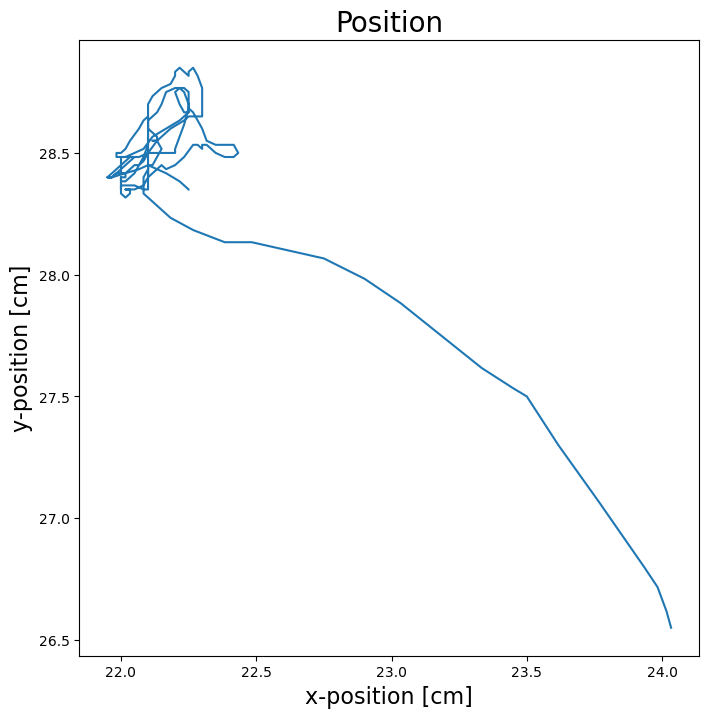

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(position_info.position_x, position_info.position_y)
ax.set_xlabel("x-position [cm]", fontsize=16)
ax.set_ylabel("y-position [cm]", fontsize=16)
ax.set_title("Position", fontsize=20)

Text(0.5, 1.0, 'Velocity')

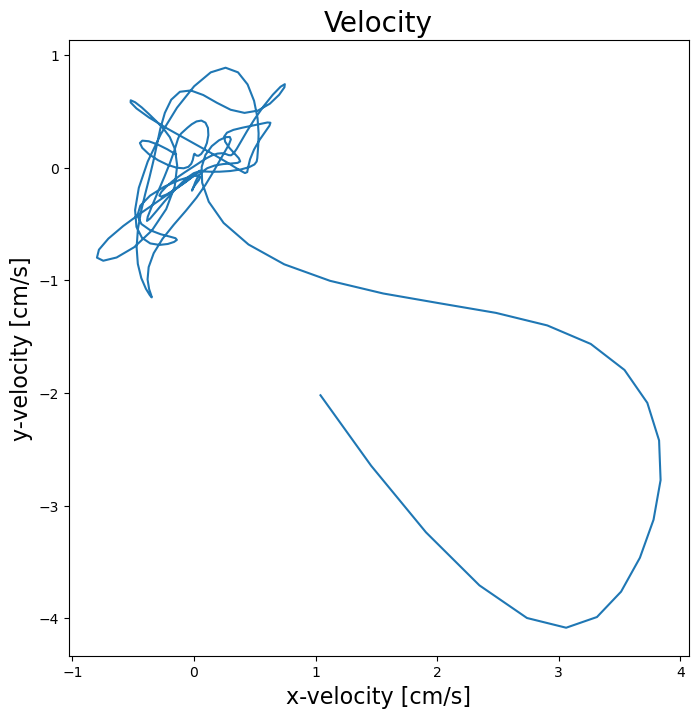

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(position_info.velocity_x, position_info.velocity_y)
ax.set_xlabel("x-velocity [cm/s]", fontsize=16)
ax.set_ylabel("y-velocity [cm/s]", fontsize=16)
ax.set_title("Velocity", fontsize=20)

(1687474800.1833298, 1687474810.565797)

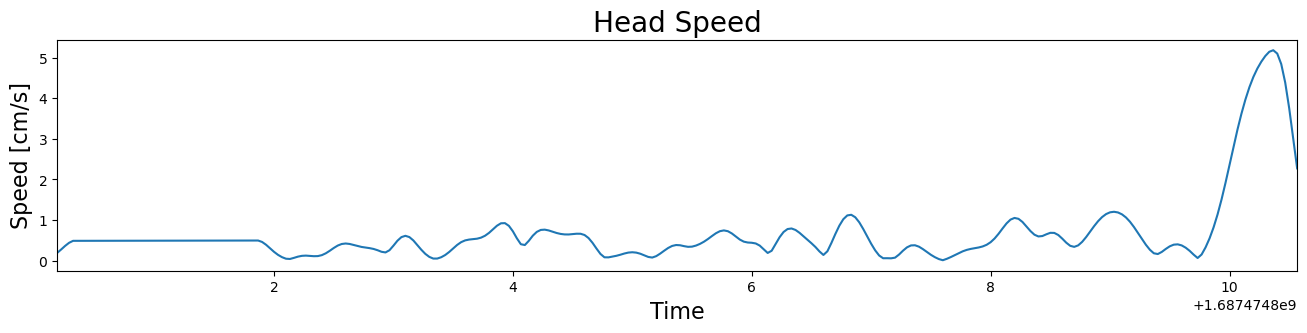

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(position_info.index, position_info.speed)
ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("Speed [cm/s]", fontsize=16)
ax.set_title("Head Speed", fontsize=20)
ax.set_xlim((position_info.index.min(), position_info.index.max()))

### Video

To keep `minirec` small, the download link does not include videos by default. 

If it is available, you can uncomment the code, populate the  `TrodesPosVideo` table, and plot the results on the video using the `make_video` function, which will appear in the current working directory.


In [19]:
# sgp.v1.TrodesPosVideo().populate(
#     {
#         "nwb_file_name": nwb_copy_file_name,
#         "interval_list_name": interval_list_name,
#         "position_info_param_name": trodes_params_name,
#     }
# )

In [20]:
# sgp.v1.TrodesPosVideo()

## Upsampling position

To get position data in smaller in time bins, we can upsample using the 
following parameters

- `is_upsampled`, default 0 (False): If 1, perform upsampling.
- `upsampling_sampling_rate`, default None: the rate to upsample to (e.g.,
  33 Hz video might be upsampled to 500 Hz).
- `upsampling_interpolation_method`, default linear: interpolation method. See
  [pandas.DataFrame.interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)
  for alternate methods.


In [21]:
trodes_params_up_name = trodes_params_name + "_upsampled"
trodes_params_up = {
    **trodes_params,
    "is_upsampled": 1,
    "upsampling_sampling_rate": 500,
}
sgp.v1.TrodesPosParams.insert1(
    {
        "trodes_pos_params_name": trodes_params_up_name,
        "params": trodes_params_up,
    },
    skip_duplicates=True,
)

sgp.v1.TrodesPosParams()

trodes_pos_params_name name for this set of parameters,params
default,=BLOB=
single_led,=BLOB=
single_led_upsampled,=BLOB=


In [22]:
trodes_s_up_key = {
    "nwb_file_name": nwb_copy_file_name,
    "interval_list_name": interval_list_name,
    "trodes_pos_params_name": trodes_params_up_name,
}
sgp.v1.TrodesPosSelection.insert1(
    trodes_s_up_key,
    skip_duplicates=True,
)
sgp.v1.TrodesPosV1.populate(trodes_s_up_key)

In [23]:
merge_key = (PositionOutput.merge_get_part(trodes_s_up_key)).fetch1("KEY")
upsampled_position_info = (PositionOutput & merge_key).fetch1_dataframe()
upsampled_position_info

[13:47:56][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
[2024-01-12 13:47:56,476][WARNING]: Skipped checksum for file with hash: 119a4889-1117-30a9-c774-3c7db7048f02, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/minirec20230622/minirec20230622_PBPM9HN98Y.nwb


,position_x,position_y,orientation,velocity_x,velocity_y,speed
time,,,,,,
1.687475e+09,22.250000,28.350000,0.808756,-0.083265,0.082262,0.117047
1.687475e+09,22.250000,28.350000,0.905134,-0.084928,0.083888,0.119373
1.687475e+09,22.250000,28.350000,0.905373,-0.086591,0.085514,0.121699
1.687475e+09,22.250000,28.350000,0.905373,-0.088254,0.087138,0.124023
1.687475e+09,22.250000,28.350000,0.905373,-0.089915,0.088760,0.126345
...,...,...,...,...,...,...
1.687475e+09,24.029412,26.565686,0.835485,1.095035,-2.036613,2.312335
1.687475e+09,24.030392,26.561765,0.835391,1.070802,-1.998650,2.267425
1.687475e+09,24.031373,26.557843,0.835298,1.046820,-1.960860,2.222792


Text(0.5, 1.0, 'Upsampled Position')

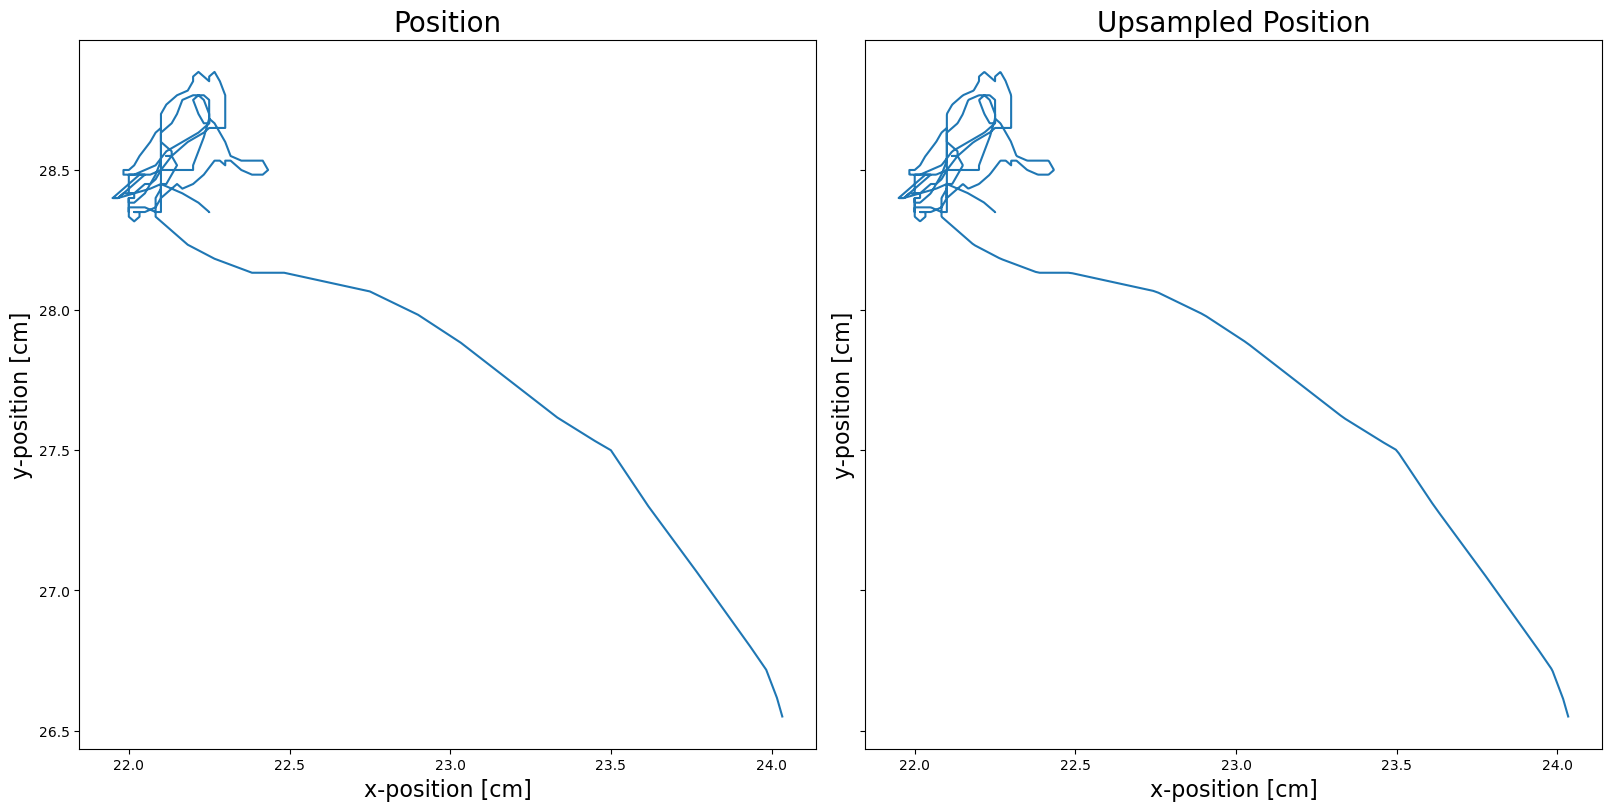

In [24]:
fig, axes = plt.subplots(
    1, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True
)
axes[0].plot(position_info.position_x, position_info.position_y)
axes[0].set_xlabel("x-position [cm]", fontsize=16)
axes[0].set_ylabel("y-position [cm]", fontsize=16)
axes[0].set_title("Position", fontsize=20)

axes[1].plot(
    upsampled_position_info.position_x,
    upsampled_position_info.position_y,
)
axes[1].set_xlabel("x-position [cm]", fontsize=16)
axes[1].set_ylabel("y-position [cm]", fontsize=16)
axes[1].set_title("Upsampled Position", fontsize=20)

Text(0.5, 1.0, 'Upsampled Speed')

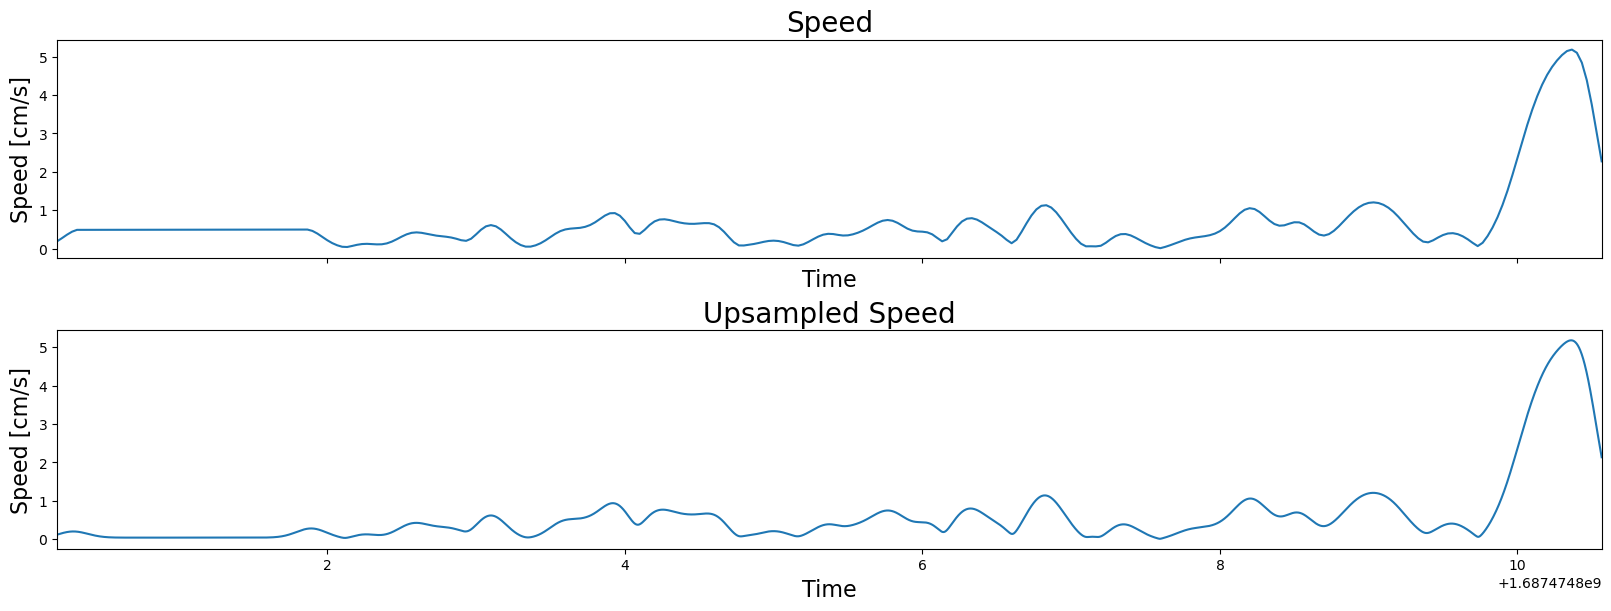

In [25]:
fig, axes = plt.subplots(
    2, 1, figsize=(16, 6), sharex=True, sharey=True, constrained_layout=True
)
axes[0].plot(position_info.index, position_info.speed)
axes[0].set_xlabel("Time", fontsize=16)
axes[0].set_ylabel("Speed [cm/s]", fontsize=16)
axes[0].set_title("Speed", fontsize=20)
axes[0].set_xlim((position_info.index.min(), position_info.index.max()))

axes[1].plot(upsampled_position_info.index, upsampled_position_info.speed)
axes[1].set_xlabel("Time", fontsize=16)
axes[1].set_ylabel("Speed [cm/s]", fontsize=16)
axes[1].set_title("Upsampled Speed", fontsize=20)

Text(0.5, 1.0, 'Upsampled Velocity')

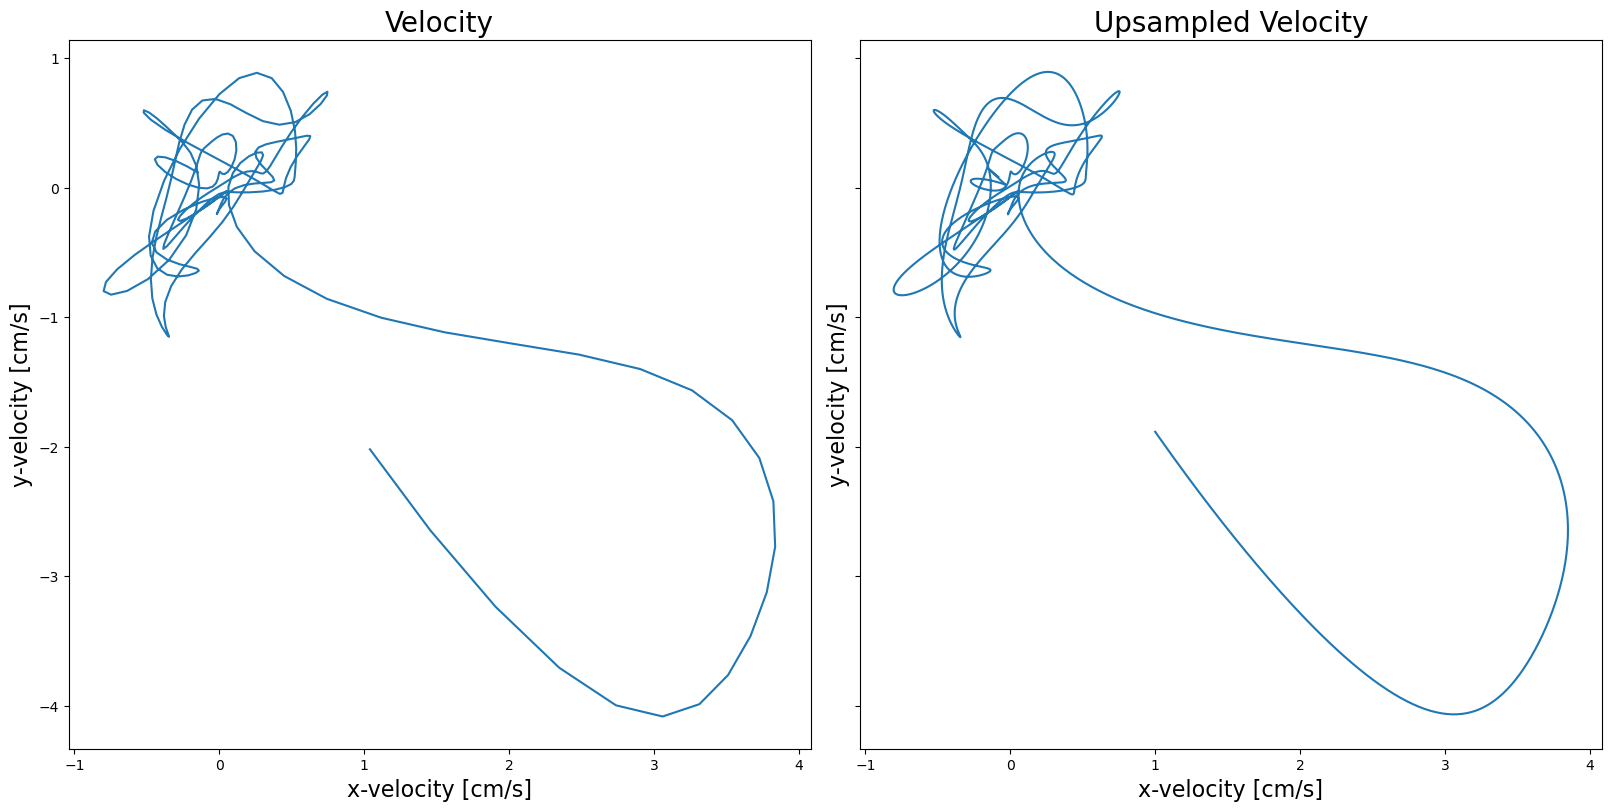

In [26]:
fig, axes = plt.subplots(
    1, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True
)
axes[0].plot(position_info.velocity_x, position_info.velocity_y)
axes[0].set_xlabel("x-velocity [cm/s]", fontsize=16)
axes[0].set_ylabel("y-velocity [cm/s]", fontsize=16)
axes[0].set_title("Velocity", fontsize=20)

axes[1].plot(
    upsampled_position_info.velocity_x,
    upsampled_position_info.velocity_y,
)
axes[1].set_xlabel("x-velocity [cm/s]", fontsize=16)
axes[1].set_ylabel("y-velocity [cm/s]", fontsize=16)
axes[1].set_title("Upsampled Velocity", fontsize=20)

## Up Next

In the [next notebook](./21_Position_DLC_1.ipynb), we'll explore using DeepLabCut to generate position data from video.
